In [1]:
import numpy as np

In [2]:
x = np.arange(100)
delta = np.random.uniform(-10, 10, size=(100,))
y = .4 * x + 3 + delta

In [3]:
import matplotlib.pyplot as plt

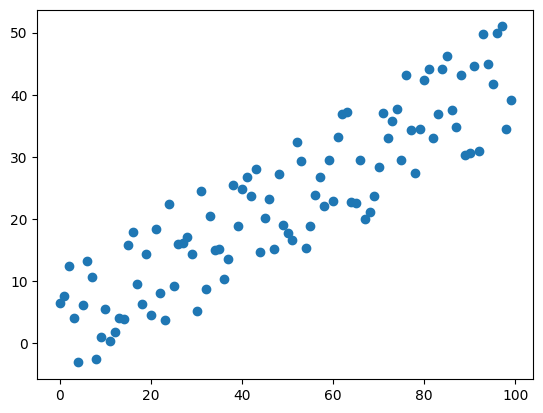

In [4]:
plt.scatter(x, y)
plt.show()

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PySpark LinReg Scatter") \
    .master("spark://172.29.16.102:7077") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/06 09:08:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
sc = spark.sparkContext

In [10]:
x_rdd = sc.parallelize(x)
y_rdd = sc.parallelize(y)

In [11]:
xy_rdd = x_rdd.zip(y_rdd)

In [13]:
xy_rdd.persist()

org.apache.spark.api.java.JavaPairRDD@14ad750e

In [88]:
# Parameters
m = 0.0  # initial slope
b = 0.0  # initial intercept
learning_rate = 0.0001
iterations = 10

N = xy_rdd.count()
for i in range(iterations):    
    # Compute predictions and errors
    predictions_rdd = xy_rdd.map(lambda x: (x[0], x[1], x[1] - (m * x[0] + b)))
    
    # Compute gradients
    gradients_rdd = predictions_rdd.map(lambda x: (
        -2 * x[0] * x[2],
        -2 * x[2]
    ))
    m_gradient = gradients_rdd.map(lambda x: x[0]).reduce(lambda a, b: a + b) / N
    b_gradient = gradients_rdd.map(lambda x: x[1]).reduce(lambda a, b: a + b) / N
    
    # Update parameters
    m -= learning_rate * m_gradient
    b -= learning_rate * b_gradient

In [89]:
# Optimized version

# Parameters
m = 0.0  # initial slope
b = 0.0  # initial intercept
learning_rate = 0.0001
iterations = 10

N = xy_rdd.count()
for i in range(iterations):    
    # Compute predictions and errors
    predictions_rdd = xy_rdd.map(lambda x: (x[0], x[1], x[1] - (m * x[0] + b)))
    
    # Compute gradients
    gradients_rdd = predictions_rdd.map(lambda x: (
        -2 * x[0] * x[2],
        -2 * x[2]
    ))
    mb_gradients = gradients_rdd.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    
    # Update parameters
    m -= learning_rate * (mb_gradients[0] / N)
    b -= learning_rate * (mb_gradients[1] / N)

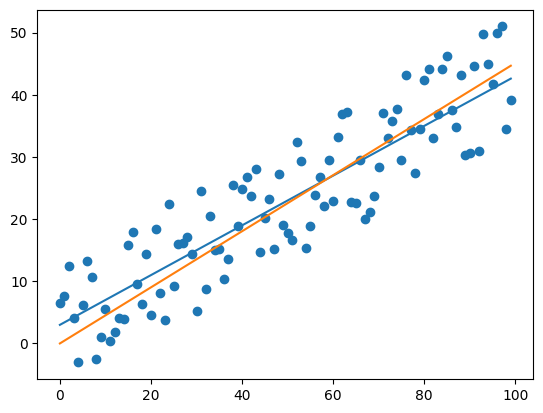

In [90]:
plt.scatter(x, y)
plt.plot(x, .4 * x + 3)
plt.plot(x, m * x + b)

plt.show()